In [1]:
import requests
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from dython.nominal import identify_nominal_columns
from dython.nominal import associations
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split, cross_validate, KFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, PowerTransformer
from sklearn.compose import ColumnTransformer, make_column_selector as selector
from sklearn.metrics import precision_score, accuracy_score, recall_score, confusion_matrix

In [2]:
diabetes_raw = pd.read_csv('https://raw.githubusercontent.com/ryskgit/QTW_CaseStudy/main/Case%20Study%202/dataset_diabetes/diabetic_data.csv')

In [3]:
pd.set_option('display.max_columns', None)
diabetes_raw.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,?,Pediatrics-Endocrinology,41,0,1,0,0,0,250.83,?,?,1,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,?,?,59,0,18,0,0,0,276,250.01,255,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,?,?,11,5,13,2,0,1,648,250,V27,6,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,?,?,44,1,16,0,0,0,8,250.43,403,7,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,?,?,51,0,8,0,0,0,197,157,250,5,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [4]:
pd.reset_option("max_columns")

In [5]:
for i in diabetes_raw.columns:
    print(i, diabetes_raw[i].unique())

encounter_id [  2278392    149190     64410 ... 443854148 443857166 443867222]
patient_nbr [  8222157  55629189  86047875 ... 140199494 120975314 175429310]
race ['Caucasian' 'AfricanAmerican' '?' 'Other' 'Asian' 'Hispanic']
gender ['Female' 'Male' 'Unknown/Invalid']
age ['[0-10)' '[10-20)' '[20-30)' '[30-40)' '[40-50)' '[50-60)' '[60-70)'
 '[70-80)' '[80-90)' '[90-100)']
weight ['?' '[75-100)' '[50-75)' '[0-25)' '[100-125)' '[25-50)' '[125-150)'
 '[175-200)' '[150-175)' '>200']
admission_type_id [6 1 2 3 4 5 8 7]
discharge_disposition_id [25  1  3  6  2  5 11  7 10  4 14 18  8 13 12 16 17 22 23  9 20 15 24 28
 19 27]
admission_source_id [ 1  7  2  4  5  6 20  3 17  8  9 14 10 22 11 25 13]
time_in_hospital [ 1  3  2  4  5 13 12  9  7 10  6 11  8 14]
payer_code ['?' 'MC' 'MD' 'HM' 'UN' 'BC' 'SP' 'CP' 'SI' 'DM' 'CM' 'CH' 'PO' 'WC' 'OT'
 'OG' 'MP' 'FR']
medical_specialty ['Pediatrics-Endocrinology' '?' 'InternalMedicine'
 'Family/GeneralPractice' 'Cardiology' 'Surgery-General' 'Orthopedic

In [6]:
diabetes_raw[diabetes_raw['gender'] == 'Unknown/Invalid']

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
30506,98634858,100695042,Other,Unknown/Invalid,[70-80),?,3,1,1,1,...,No,No,No,No,No,No,No,Ch,Yes,NO
75551,226864668,60524946,?,Unknown/Invalid,[60-70),?,1,1,7,1,...,No,No,No,No,No,No,No,No,No,NO
82573,257364294,78119847,?,Unknown/Invalid,[70-80),?,1,22,7,8,...,No,No,No,No,No,No,No,Ch,Yes,NO


In [7]:
# copy raw diabetes data into new df
diabetes = diabetes_raw.copy()

# removed three rows with unknown gender values
diabetes = diabetes[diabetes['gender'] != 'Unknown/Invalid']

# recode change yes or no to binary
diabetes["change"] = diabetes["change"].replace({"Ch":0, "No":1})

# recode diabetesMed yes or no to binary
diabetes["diabetesMed"] = diabetes["diabetesMed"].replace({"Yes":0, "No":1})

# create recode object for age from categorical to ordinal (values mean ages less than designated value, e.g. [0-10) means including 0 but not 10])
age_recode = {"[0-10)":10, "[10-20)":20, "[20-30)":30, "[30-40)":40, "[40-50)":50, "[50-60)":60, "[60-70)":70, "[70-80)":80, "[80-90)":90, "[90-100)":100}
diabetes["age"] = diabetes["age"].replace(age_recode)

# recode gender to binary
diabetes["gender"] = diabetes["gender"].replace({"Female":0, "Male":1})

diabetes = diabetes.rename({'change': 'changeYes0', 'diabetesMed': 'diabetesMedYes0', 'gender': 'female0'}, axis=1)

In [8]:
diabetes.head()

,encounter_id,patient_nbr,race,female0,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,changeYes0,diabetesMedYes0,readmitted
0,2278392,8222157,Caucasian,0,10,?,6,25,1,1,...,No,No,No,No,No,No,No,1,1,NO
1,149190,55629189,Caucasian,0,20,?,1,1,7,3,...,No,Up,No,No,No,No,No,0,0,>30
2,64410,86047875,AfricanAmerican,0,30,?,1,1,7,2,...,No,No,No,No,No,No,No,1,0,NO
3,500364,82442376,Caucasian,1,40,?,1,1,7,2,...,No,Up,No,No,No,No,No,0,0,NO
4,16680,42519267,Caucasian,1,50,?,1,1,7,1,...,No,Steady,No,No,No,No,No,0,0,NO


In [9]:
def custom_range(column):
    mean = column.mean()
    min = column.min()
    max = column.max()
    print(f'Mean : {mean}')
    print(f'Min : {min}')
    print(f'Max : {max}')

In [10]:
print(f'Simple Summary Statistics for Numeric Columns')
for i in diabetes.columns:
    if diabetes[i].dtypes == 'int64':
        print(f'{i}')
        custom_range(diabetes[i])
        print('------------')


Simple Summary Statistics for Numeric Columns
encounter_id
Mean : 165200788.15137133
Min : 12522
Max : 443867222
------------
patient_nbr
Mean : 54329650.43568881
Min : 135
Max : 189502619
------------
female0
Mean : 0.46239792458948736
Min : 0
Max : 1
------------
age
Mean : 70.96685435767421
Min : 10
Max : 100
------------
admission_type_id
Mean : 2.0240165875612943
Min : 1
Max : 8
------------
discharge_disposition_id
Mean : 3.7155154623979247
Min : 1
Max : 28
------------
admission_source_id
Mean : 5.7544588897732964
Min : 1
Max : 25
------------
time_in_hospital
Mean : 4.396018199149003
Min : 1
Max : 14
------------
num_lab_procedures
Mean : 43.09590912217604
Min : 1
Max : 132
------------
num_procedures
Mean : 1.3396912433792243
Min : 0
Max : 6
------------
num_medications
Mean : 16.021835048101963
Min : 1
Max : 81
------------
number_outpatient
Mean : 0.36936804142959623
Min : 0
Max : 42
------------
number_emergency
Mean : 0.19784204475103917
Min : 0
Max : 76
------------
numbe

in 'discharge_disposition', no instances with value of '29'
in 'admission_source_id', no instance with value of '26'

array([[<AxesSubplot:title={'center':'encounter_id'}>,
        <AxesSubplot:title={'center':'patient_nbr'}>,
        <AxesSubplot:title={'center':'female0'}>,
        <AxesSubplot:title={'center':'age'}>],
       [<AxesSubplot:title={'center':'admission_type_id'}>,
        <AxesSubplot:title={'center':'discharge_disposition_id'}>,
        <AxesSubplot:title={'center':'admission_source_id'}>,
        <AxesSubplot:title={'center':'time_in_hospital'}>],
       [<AxesSubplot:title={'center':'num_lab_procedures'}>,
        <AxesSubplot:title={'center':'num_procedures'}>,
        <AxesSubplot:title={'center':'num_medications'}>,
        <AxesSubplot:title={'center':'number_outpatient'}>],
       [<AxesSubplot:title={'center':'number_emergency'}>,
        <AxesSubplot:title={'center':'number_inpatient'}>,
        <AxesSubplot:title={'center':'number_diagnoses'}>,
        <AxesSubplot:title={'center':'changeYes0'}>],
       [<AxesSubplot:title={'center':'diabetesMedYes0'}>, <AxesSubplot:>,
   

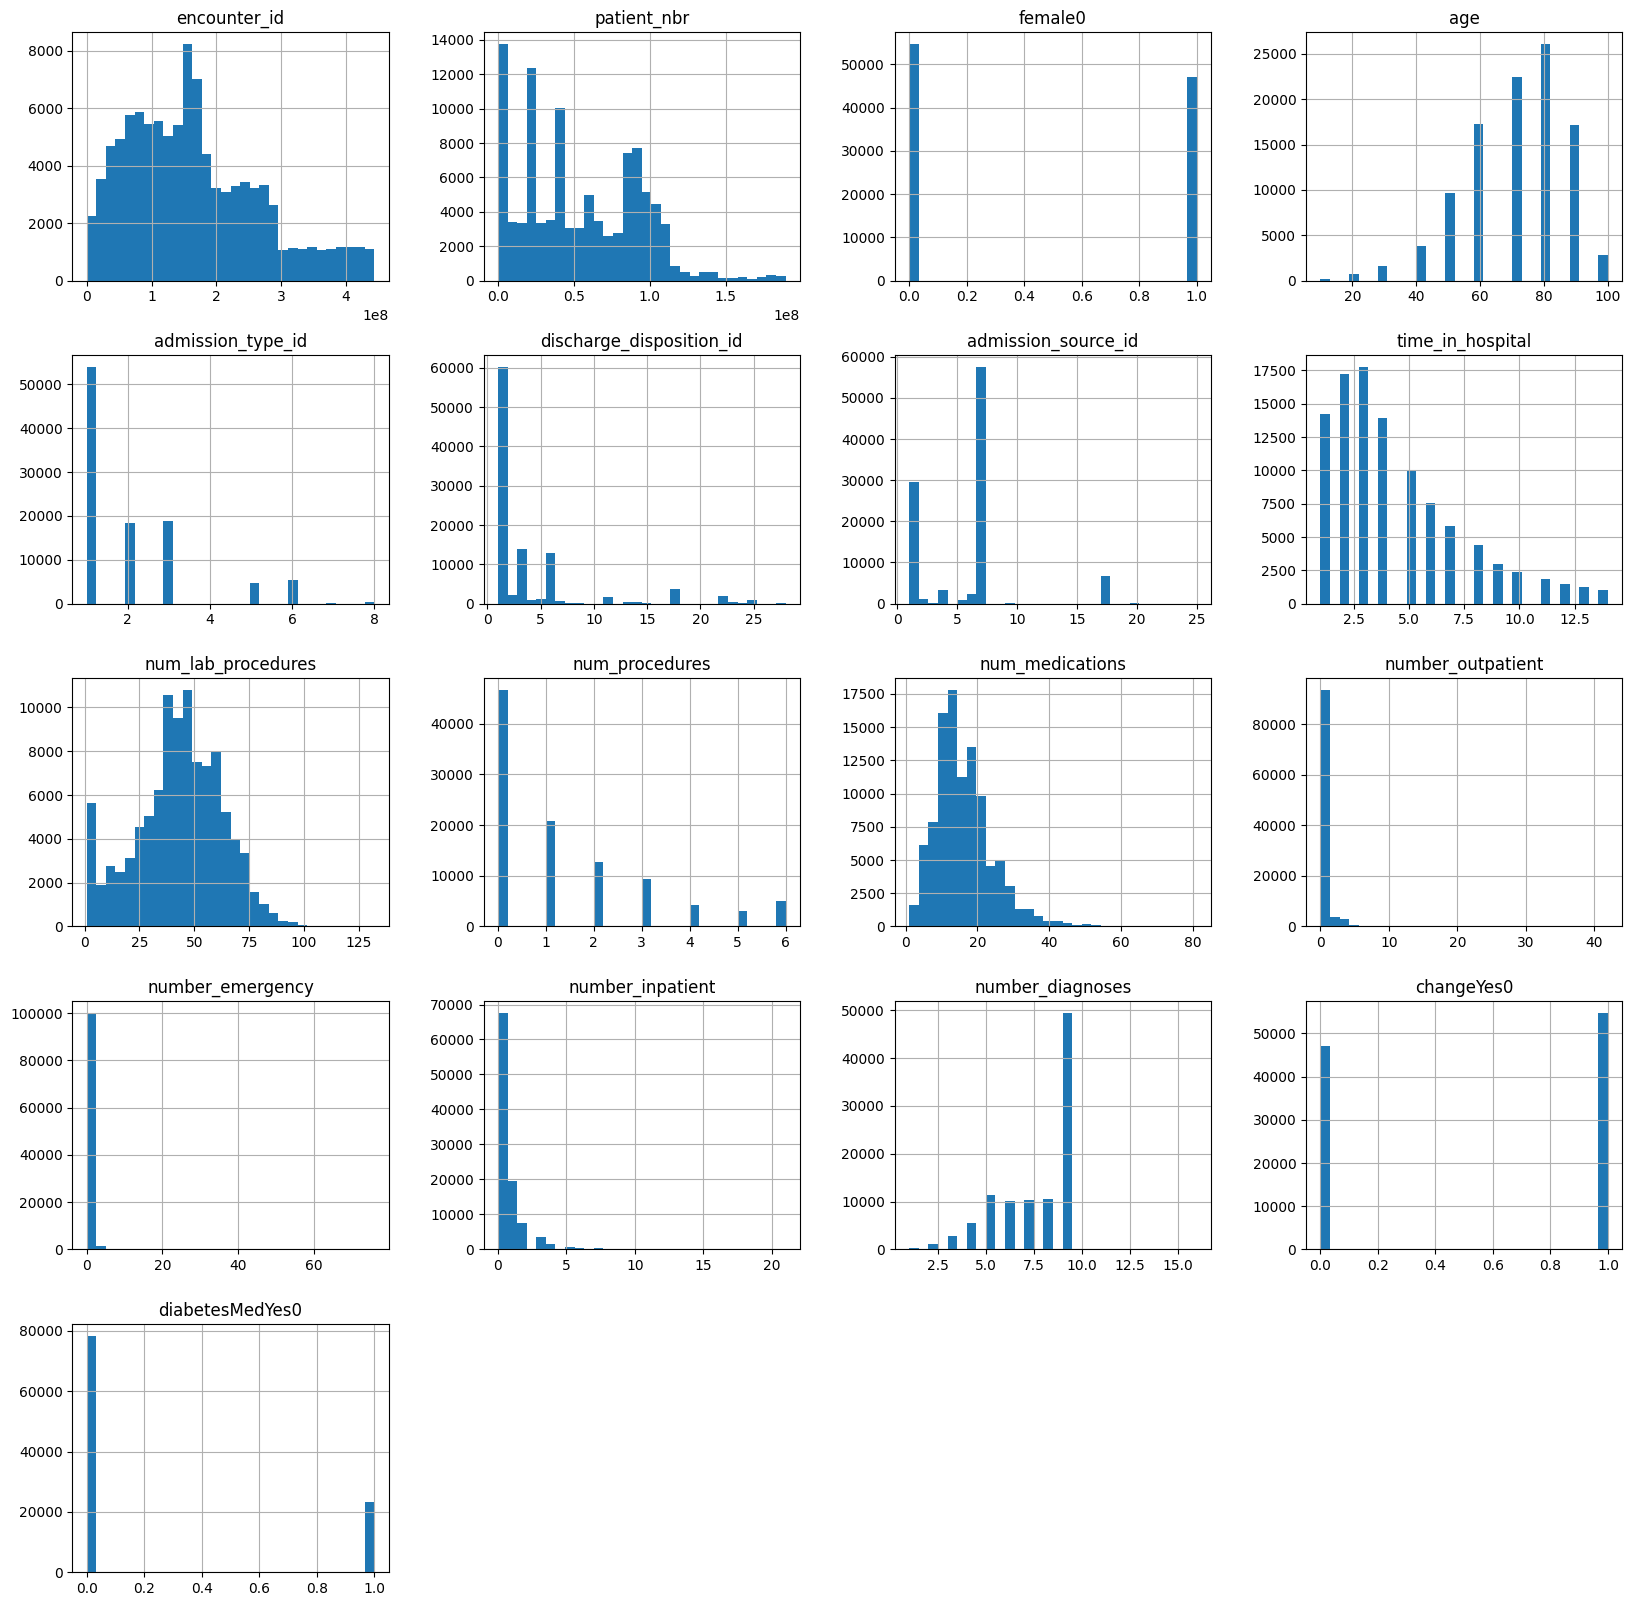

In [11]:
diabetes.hist(bins=30, figsize=(20, 20))

In [12]:
# value counts for each 'object' dtype
for i in diabetes.columns:
    if diabetes[i].dtypes == 'O':
        print(f'{i}')
        value = diabetes[i].value_counts()
        print(f'{value}')
        print('------------')
    else:
        pass

race
Caucasian          76099
AfricanAmerican    19210
?                   2271
Hispanic            2037
Other               1505
Asian                641
Name: race, dtype: int64
------------
weight
?            98566
[75-100)      1336
[50-75)        897
[100-125)      625
[125-150)      145
[25-50)         97
[0-25)          48
[150-175)       35
[175-200)       11
>200             3
Name: weight, dtype: int64
------------
payer_code
?     40255
MC    32439
HM     6274
SP     5007
BC     4655
MD     3532
CP     2531
UN     2448
CM     1937
OG     1033
PO      592
DM      549
CH      146
WC      135
OT       95
MP       79
SI       55
FR        1
Name: payer_code, dtype: int64
------------
medical_specialty
?                                49947
InternalMedicine                 14635
Emergency/Trauma                  7565
Family/GeneralPractice            7440
Cardiology                        5351
                                 ...  
SportsMedicine                       1
Speech  

In [13]:
diabetes.dtypes.head()

encounter_id     int64
patient_nbr      int64
race            object
female0          int64
age              int64
dtype: object

In [14]:
# missing values, but doesn't register bc the values reflect '?' rather than Nan
maybeMissingCols = diabetes.isna().sum()
maybeMissingCols[maybeMissingCols > 0]

Series([], dtype: int64)

In [15]:
# create copy to keep original dataset without manipulation
# missing values are displayed with a '?', so replace with Nan, which pandas can identify as a missing value
db_2 = diabetes.copy()
db_2[db_2=='?'] = np.nan

In [16]:
# 7 columns with missing values
missingCols = db_2.isna().sum()
missingCols[missingCols > 0]

race                  2271
weight               98566
payer_code           40255
medical_specialty    49947
diag_1                  21
diag_2                 358
diag_3                1423
dtype: int64

In [17]:
# remove single value columns, no predictive value
# remove weight as almost all values are missing
# remove missing values in diag_1,2,3 since they make up less than 1% of total number of rows
single_vals = db_2.columns[db_2.eq(db_2.iloc[0]).all()].tolist()
print(f"There are {len(single_vals)} columns with single values: {single_vals}")
print(f"Original data dimension: {db_2.shape}")
db_2.drop(columns=single_vals, inplace=True)
db_2.drop(columns = 'weight', inplace = True)
db_2.dropna(subset = ['diag_1', 'diag_2', 'diag_3'], inplace = True)
print(f"Final data dim after dropping aforementioned columns: {db_2.shape}")
print(f"There are {db_2.isna().sum().sum()} NA values and {db_2.duplicated().sum()} duplicated records")

There are 2 columns with single values: ['examide', 'citoglipton']
Original data dimension: (101763, 50)
Final data dim after dropping aforementioned columns: (100241, 47)
There are 91123 NA values and 0 duplicated records


In [18]:
# train/test split before imputing missing values
train, test = train_test_split(db_2, test_size=0.2, random_state=42)

In [19]:
# dimensions after 80/20 train/test split
print(f'Dimensions of train: {train.shape}')
print(f'Dimenstions of test: {test.shape}')

Dimensions of train: (80192, 47)
Dimenstions of test: (20049, 47)


In [20]:
# specific columns with missing values
# a bit concerned about weight, payer_code, and medical_specialty given the amount of missing values. might not be worth imputing?
print(f'Columns with missing values:')
miss_val_col = []
for i in train.columns:
    val = train[i].isna().sum()
    if val > 0:
        print(f'{i} : {val}')
        miss_val_col.append(i)

Columns with missing values:
race : 1744
payer_code : 31496
medical_specialty : 39649


In [21]:
# since all missing value columns are categorical, we can try imputing with the mode first
for i in miss_val_col:
    val = train[i].dtypes
    print(val)

object
object
object


In [22]:
# create copies of train,test to impute with mode of each var
test_mode = test.copy()
train_mode = train.copy()
for i in miss_val_col:
    train_mode[i] = train_mode[i].fillna(train_mode[i].mode()[0])
    test_mode[i] = test_mode[i].fillna(train_mode[i].mode()[0])

In [23]:
# missing values in 'mode' set is zero
train_mode.isna().sum().sum()

0

### Imputing via correlation and regression

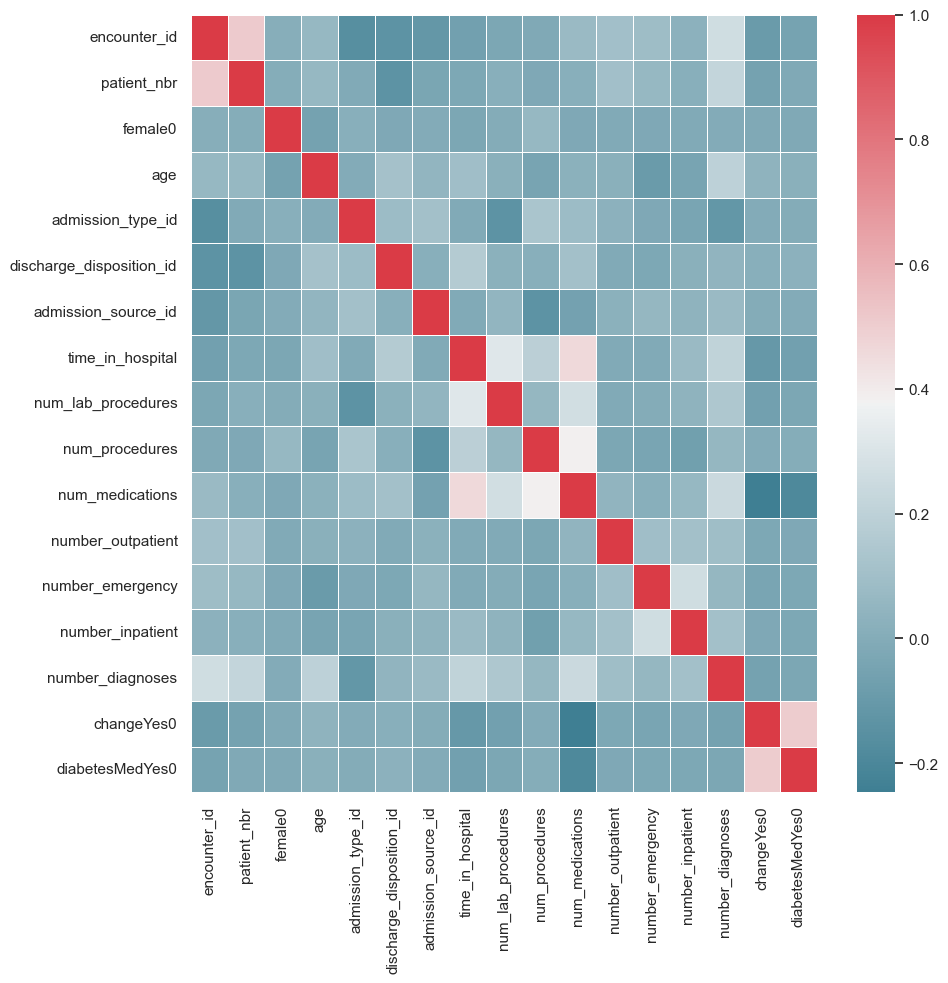

In [24]:
# Numeric Correlation Matrix, doesn't give much indication to corr of categorical variables
sns.set()
sns.set(style='darkgrid')
cmap = sns.diverging_palette(220, 10, as_cmap=True)
f, ax= plt.subplots(figsize=(10,10))

sns.heatmap(train.corr(),cmap=cmap,fmt='.3f',linewidth=.5,ax=ax)
f.tight_layout()

In [25]:
cat_features = identify_nominal_columns(train)
len(cat_features)

30

In [26]:
%%capture
complete_correlation= associations(train, figsize=(25,25))

In [27]:
df_complete_corr=complete_correlation['corr']
df_complete_corr.dropna(axis=1, how='all').dropna(axis=0, how='all').style.background_gradient(cmap='coolwarm', axis=None).set_precision(2)

/var/folders/8r/5z1j8hgs59d95j_4d6czqrf80000gn/T/ipykernel_67269/1661098780.py:2: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  df_complete_corr.dropna(axis=1, how='all').dropna(axis=0, how='all').style.background_gradient(cmap='coolwarm', axis=None).set_precision(2)


,encounter_id,patient_nbr,race,female0,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,changeYes0,diabetesMedYes0,readmitted
encounter_id,1.00,0.51,0.10,0.01,0.06,-0.16,-0.14,-0.11,-0.07,0.56,0.37,-0.03,-0.02,0.07,0.10,0.09,0.03,0.17,0.27,0.21,0.26,0.16,0.06,0.04,0.02,0.02,0.02,0.04,0.00,0.03,0.08,0.01,0.05,0.05,0.01,0.00,0.01,0.02,0.15,0.03,0.00,0.00,0.01,0.01,-0.10,-0.05,0.04
patient_nbr,0.51,1.00,0.16,0.00,0.06,-0.01,-0.14,-0.03,-0.03,0.31,0.33,0.01,-0.02,0.02,0.10,0.06,0.01,0.15,0.18,0.16,0.22,0.10,0.04,0.02,0.05,0.02,0.01,0.03,0.00,0.02,0.06,0.00,0.04,0.01,0.01,0.01,0.00,0.02,0.08,0.03,0.00,0.00,0.01,0.00,-0.05,-0.02,0.07
race,0.10,0.16,1.00,0.07,0.19,0.11,0.04,0.04,0.03,0.09,0.09,0.03,0.04,0.07,0.06,0.04,0.05,0.11,0.11,0.08,0.11,0.04,0.03,0.01,0.02,0.01,0.01,0.01,0.00,0.01,0.02,0.00,0.01,0.01,0.01,0.00,0.00,0.00,0.04,0.02,0.00,0.00,0.03,0.00,0.02,0.02,0.04
female0,0.01,0.00,0.07,1.00,-0.05,0.01,-0.02,-0.00,-0.03,0.09,0.12,-0.00,0.06,-0.02,-0.01,-0.02,-0.01,0.24,0.21,0.20,-0.00,0.00,0.02,0.01,0.01,0.01,0.01,0.01,0.00,0.03,0.03,0.00,0.01,0.02,0.01,0.01,0.01,0.01,0.01,0.00,0.01,0.00,0.01,0.00,-0.02,-0.02,0.02
age,0.06,0.06,0.19,-0.05,1.00,-0.01,0.11,0.05,0.10,0.42,0.23,0.02,-0.04,0.02,0.02,-0.09,-0.04,0.49,0.40,0.38,0.20,0.05,0.15,0.07,0.05,0.02,0.02,0.04,0.00,0.05,0.08,0.01,0.01,0.00,0.01,0.01,0.00,0.01,0.09,0.00,0.00,0.00,0.00,0.00,0.04,0.02,0.03
admission_type_id,-0.16,-0.01,0.11,0.01,-0.01,1.00,0.08,0.11,-0.01,0.20,0.29,-0.14,0.13,0.08,0.03,-0.02,-0.04,0.30,0.18,0.16,-0.12,0.40,0.06,0.01,0.00,0.01,0.01,0.00,0.00,0.01,0.01,0.01,0.02,0.02,0.01,0.00,0.00,0.01,0.04,0.01,0.00,0.00,0.00,0.00,-0.01,-0.00,0.01
discharge_disposition_id,-0.14,-0.14,0.04,-0.02,0.11,0.08,1.00,0.01,0.16,0.17,0.16,0.03,0.02,0.11,-0.01,-0.02,0.02,0.24,0.17,0.17,0.04,0.04,0.02,0.02,0.01,0.01,0.02,0.03,0.00,0.02,0.05,0.00,0.02,0.01,0.01,0.01,0.01,0.01,0.05,0.01,0.00,0.00,0.00,0.00,0.01,0.03,0.06
admission_source_id,-0.11,-0.03,0.04,-0.00,0.05,0.11,0.01,1.00,-0.01,0.13,0.30,0.05,-0.14,-0.06,0.02,0.06,0.04,0.32,0.20,0.17,0.07,0.48,0.01,0.04,0.01,0.02,0.01,0.02,0.00,0.01,0.01,0.01,0.01,0.01,0.01,0.00,0.00,0.00,0.03,0.03,0.00,0.00,0.00,0.00,-0.00,-0.00,0.04
time_in_hospital,-0.07,-0.03,0.03,-0.03,0.10,-0.01,0.16,-0.01,1.00,0.09,0.17,0.32,0.19,0.46,-0.01,-0.01,0.07,0.38,0.32,0.32,0.21,0.05,0.07,0.04,0.04,0.01,0.01,0.04,0.00,0.06,0.05,0.00,0.04,0.03,0.01,0.01,0.00,0.01,0.14,0.01,0.00,0.00,0.00,0.00,-0.11,-0.07,0.05
payer_code,0.56,0.31,0.09,0.09,0.42,0.20,0.17,0.13,0.09,1.00,0.11,0.09,0.09,0.07,0.14,0.15,0.08,0.12,0.12,0.11,0.18,0.08,0.07,0.05,0.02,0.01,0.00,0.03,0.00,0.02,0.04,0.00,0.03,0.02,0.01,0.00,0.00,0.00,0.13,0.04,0.01,0.01,0.02,0.02,0.15,0.10,0.05


In [28]:
corr_df = complete_correlation['corr']

In [29]:
# correlation values for all columns with missing values. Unfortunately, correlations seem really low and unlikely to predict missing values accurately
for i in miss_val_col:
    print(f'{i.upper()}:')
    value = corr_df[i].nlargest(4, 'first')
    print(value[1:])
    print('------------')

RACE:
age                 0.186034
patient_nbr         0.164111
number_diagnoses    0.114596
Name: race, dtype: float64
------------
PAYER_CODE:
encounter_id    0.557960
age             0.416223
patient_nbr     0.305249
Name: payer_code, dtype: float64
------------
MEDICAL_SPECIALTY:
encounter_id           0.369599
patient_nbr            0.330938
admission_source_id    0.297008
Name: medical_specialty, dtype: float64
------------


In [30]:
train_2 = train.copy()

cat_vals = []
for i in train_2.columns:
    if diabetes[i].dtypes == 'O':
        print(f'{i}')
        value = train_2[i].value_counts()
        print(f'{value}')
        print('------------')
        cat_vals.append(i)

    else:
        pass

race
Caucasian          60041
AfricanAmerican    15123
Hispanic            1611
Other               1179
Asian                494
Name: race, dtype: int64
------------
payer_code
MC    25833
HM     4950
SP     3936
BC     3665
MD     2792
CP     1993
UN     1879
CM     1550
OG      812
PO      461
DM      425
CH      115
WC      110
OT       72
MP       64
SI       38
FR        1
Name: payer_code, dtype: int64
------------
medical_specialty
InternalMedicine          11431
Emergency/Trauma           6003
Family/GeneralPractice     5838
Cardiology                 4293
Surgery-General            2418
                          ...  
Proctology                    1
Speech                        1
Resident                      1
Dermatology                   1
Psychiatry-Addictive          1
Name: medical_specialty, Length: 69, dtype: int64
------------
diag_1
428    5522
414    5218
786    3170
410    2890
486    2799
       ... 
97        1
31        1
827       1
580       1
373       1
N

In [31]:
# change all 'object' vars into 'category'
for i in cat_vals:
    train_2[i] = pd.Categorical(train_2[i])

train_2.dtypes

encounter_id                   int64
patient_nbr                    int64
race                        category
female0                        int64
age                            int64
admission_type_id              int64
discharge_disposition_id       int64
admission_source_id            int64
time_in_hospital               int64
payer_code                  category
medical_specialty           category
num_lab_procedures             int64
num_procedures                 int64
num_medications                int64
number_outpatient              int64
number_emergency               int64
number_inpatient               int64
diag_1                      category
diag_2                      category
diag_3                      category
number_diagnoses               int64
max_glu_serum               category
A1Cresult                   category
metformin                   category
repaglinide                 category
nateglinide                 category
chlorpropamide              category
g

In [32]:
numeric_pipeline = Pipeline(steps=[('num_imputer', SimpleImputer(strategy="median")),
                                   ('scaler', PowerTransformer(method="yeo-johnson"))])

nominal_pipeline = Pipeline(steps=[('nom_imputer', SimpleImputer(strategy="most_frequent")), 
                                   ('nom_encoder', OneHotEncoder(handle_unknown="infrequent_if_exist"))])


preprocess = ColumnTransformer(transformers=[("numeric_feats", numeric_pipeline, selector(dtype_include=int)), 
                                             ("nom_cat_feats", nominal_pipeline, selector(dtype_include=[object, 'category']))],
                               remainder="passthrough",
                               sparse_threshold=0.3)

model = Pipeline(steps=[("preprocess", preprocess), 
                        ("logreg", LogisticRegression(random_state=42, 
                                                      multi_class="multinomial", 
                                                      max_iter=10_000))])

In [33]:
train_3 = train_2.copy()
train_3.dropna(subset = 'race', inplace=True)

results = cross_validate(estimator=model, 
                X=train_3.drop(columns="race"), 
                y=train_3["race"], 
                cv=5, 
                return_estimator=True,
                scoring="accuracy", 
                         error_score="raise")

In [34]:
results.keys()
results['test_score']

array([0.77928617, 0.78081581, 0.77718292, 0.78080184, 0.78086557])

In [35]:
final_train = train_2.copy()
a = 0
for i in miss_val_col:
    train_4 = train_2.copy()
    train_4.dropna(subset = i, inplace = True)
    X = train_4.drop(columns =[i, 'readmitted'])
    y = train_4[i]
    model.fit(X,y)
    train_5 = train_2.copy()
    X = train_5.drop(columns=[i, 'readmitted'])
    new_values = model.predict(X)
    new_df = pd.DataFrame(data = new_values, columns = ['new_pred'])
    final_train.insert(loc = a, column = 'new_pred', value = new_values)
    final_train[i] = final_train[i].fillna(final_train['new_pred'])
    final_train = final_train.drop(columns =['new_pred'])
    a+=1

final_train.head(5)

,encounter_id,patient_nbr,race,female0,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,...,tolazamide,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,changeYes0,diabetesMedYes0,readmitted
52598,155387280,84471543,Caucasian,0,90,1,6,7,6,HM,...,No,No,No,No,No,No,No,1,0,NO
59449,167271414,23329413,AfricanAmerican,0,30,3,1,1,5,BC,...,No,Up,No,No,No,No,No,0,0,<30
57208,163472328,91748880,Caucasian,1,60,1,1,7,10,MC,...,No,No,No,No,No,No,No,1,0,NO
47164,145172238,85095711,AfricanAmerican,1,60,2,1,1,1,BC,...,No,No,No,No,No,No,No,0,0,>30
70475,202212546,84326805,Caucasian,1,70,1,1,7,2,HM,...,No,No,No,No,No,No,No,1,0,>30


In [36]:
final_train.isna().sum().sum()

0

### Classifying Readmittance

Regression

In [42]:
# sets for model fit and prediction (regression)
X_test = test.drop(columns = ['readmitted'])
y_test = test['readmitted']
X_train = final_train.drop(columns = ['readmitted'])
y_train = final_train['readmitted']

In [43]:
model.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numeric_feats',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   PowerTransformer())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x12afde200>),
                                                 ('nom_cat_feats',
                                                  Pipeline(steps=[('nom_imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('nom_encoder',
                                                                   OneHotEncoder(handle_unknown='infrequent_if_exist'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x12b0535b0>)])),
                ('logreg',
                 LogisticRegression(max_iter=10000, multi_class='multinomial',
                                    random_state=42))])

In [44]:
# create prediction array
X_test_pred = model.predict(X_test)

Mode

In [47]:
X_train_mode = train_mode.drop(columns = ['readmitted'])
y_train_mode = train_mode['readmitted']

In [48]:
model.fit(X_train_mode, y_train_mode)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numeric_feats',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   PowerTransformer())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x12afde200>),
                                                 ('nom_cat_feats',
                                                  Pipeline(steps=[('nom_imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('nom_encoder',
                                                                   OneHotEncoder(handle_unknown='infrequent_if_exist'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x12b0535b0>)])),
                ('logreg',
                 LogisticRegression(max_iter=10000, multi_class='multinomial',
                                    random_state=42))])

In [49]:
# Create prediction array
y_test_mode_pred = model.predict(X_test)

Evaluate Models

In [66]:
# Function to print and return Accuracy, Precision, and Recall
def eval_metrics(y_test, y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average = 'micro')
    recall = recall_score(y_test, y_pred, average = 'weighted')
    print(f'Evaluative Metrics')
    print('----------------')
    print(f'Accuracy: {accuracy}')
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')
    return (accuracy, precision, recall)

    

In [77]:
# Assigning Metrics for Mode
mode_eval = eval_metrics(y_test, y_test_mode_pred)
mode_cm = np.array(confusion_matrix(y_test, y_test_mode_pred))

Evaluative Metrics
----------------
Accuracy: 0.5863135318469749
Precision: 0.5863135318469749
Recall: 0.5863135318469749


In [86]:
# Confusion Matrix for Mode
pd.DataFrame(mode_cm, index = ['<30', '>30', 'NO'],
columns = ['predicted_<30', 'predicted_>30', 'predicted_NO'])

,predicted_<30,predicted_>30,predicted_NO
<30,28,880,1305
>30,34,2857,4100
NO,49,1926,8870


In [78]:
# Assigning metrics for Regression model
reg_eval = eval_metrics(y_test, X_test_pred)
reg_cm = np.array(confusion_matrix(y_test, X_test_pred))

Evaluative Metrics
----------------
Accuracy: 0.5857648760536686
Precision: 0.5857648760536686
Recall: 0.5857648760536686


In [87]:
# Confusion Matrix for Regression model
pd.DataFrame(reg_cm, index = ['<30', '>30', 'NO'],
columns = ['predicted_<30', 'predicted_>30', 'predicted_NO'])

,predicted_<30,predicted_>30,predicted_NO
<30,29,900,1284
>30,42,2897,4052
NO,51,1976,8818


In [88]:
# Code Attribution to Dennis Trimarchi (https://github.com/DTrimarchi10/confusion_matrix)
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

Visualizations

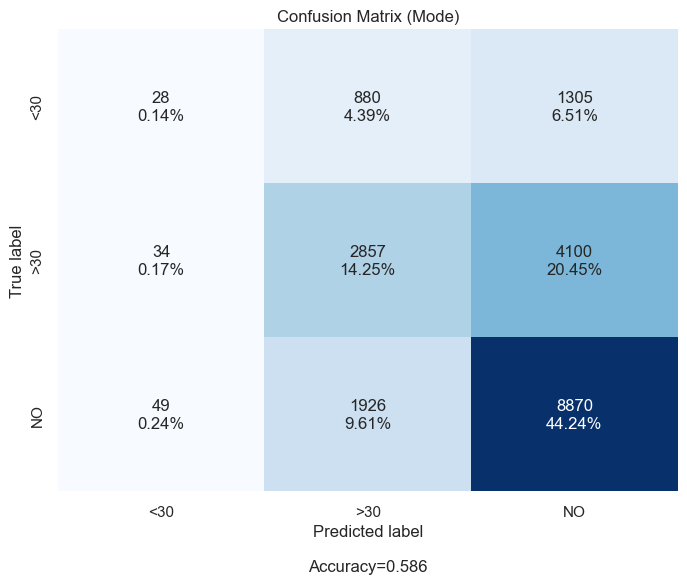

In [91]:
make_confusion_matrix(mode_cm, categories = ['<30', '>30', 'NO'], figsize = (8,6), cbar = False, title = 'Confusion Matrix (Mode)')

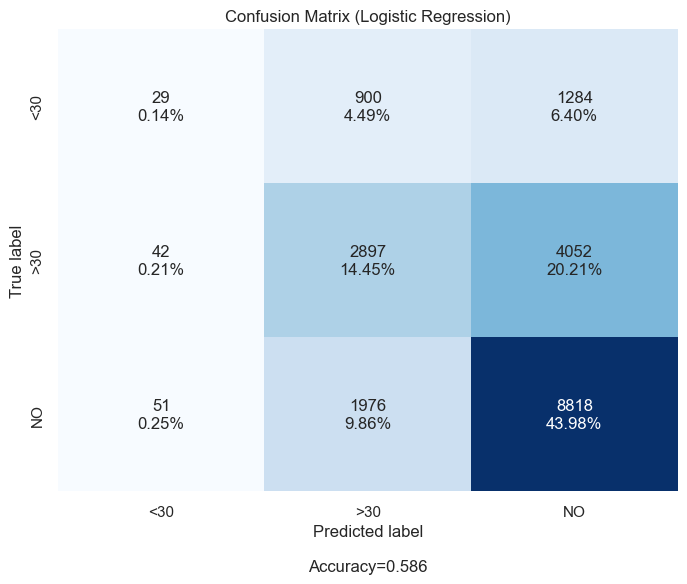

In [92]:
make_confusion_matrix(reg_cm, categories = ['<30', '>30', 'NO'], figsize = (8,6), cbar = False, title = 'Confusion Matrix (Logistic Regression)')